<a href="https://colab.research.google.com/github/pradyumna-singh/MetricsMLNotebooks/blob/main/MS%26E_228_HW_7_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MS&E 228 Homework 7**: Part 2
Due March 23

In [ ]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

In [ ]:
from itertools import count
import os
import re
import scipy
import scipy.special
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS
from sklearn.base import clone
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV,LogisticRegression, LinearRegression, ElasticNetCV

from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
!pip install flaml[notebook];
from flaml import AutoML
os.environ['PYTHONWARNINGS'] = 'ignore'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from flaml import AutoML
from sklearn.base import BaseEstimator, clone
import warnings
warnings.simplefilter('ignore')
###################################
# AutoML models
###################################

# FLAML models don't return "self" at end of fit. We create this wrapper.


class AutoMLWrap(BaseEstimator):

    def __init__(self, *, model):
        self.model = model

    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model_.predict(X)


def auto_reg(X, y, *, groups=None, n_splits=5, split_type='auto', time_budget=60, verbose=0):
    X = np.array(X)
    automl = AutoML(task='regression', time_budget=time_budget, early_stop=True,
                    eval_method='cv', n_splits=n_splits, split_type=split_type,
                    metric='mse', verbose=verbose)
    inds = np.arange(X.shape[0])
    np.random.shuffle(inds)
    if groups is None:
        automl.fit(X[inds], y[inds])
    else:
        automl.fit(X[inds], y[inds], groups=groups[inds])
    best_est = automl.best_estimator
    return lambda: AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))


class AutoMLWrapCLF(BaseEstimator):

    def __init__(self, *, model):
        self.model = model

    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model_.predict_proba(X)[:, 1]

# By default if we use metric='mse' for a classification task, then flaml
# will use `predict` instead of `predict_proba`. We define a custom mse
# loss for classification.
def clf_mse(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    val_loss = np.mean((estimator.predict_proba(X_val)[:, 1] - y_val)**2)
    return val_loss, {"val_loss": val_loss}

def auto_clf(X, y, *, groups=None, n_splits=5, split_type='auto', time_budget=60, verbose=0):
    X = np.array(X)
    automl = AutoML(task='classification', time_budget=time_budget, early_stop=True,
                    eval_method='cv', n_splits=n_splits, split_type=split_type,
                    metric=clf_mse, verbose=verbose)
    inds = np.arange(X.shape[0])
    np.random.shuffle(inds)
    if groups is None:
        automl.fit(X[inds], y[inds])
    else:
        automl.fit(X[inds], y[inds], groups=groups[inds])
    best_est = automl.best_estimator
    return lambda: AutoMLWrapCLF(model=clone(automl.best_model_for_estimator(best_est)))


# We create a custom metric to handle sample weights as we want them in RLearner (NonParamDML).
# We want to be minimizing the loss: 1/n sum_i w_i (y_i - ypred_i)^2. The standard
# mse with sample weights would have minimized (1/sum_i w_i) sum_i w_i (y_i - ypred_i)^2.
def weighted_mse(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    weight_val = 1 if weight_val is None else weight_val
    weight_train = 1 if weight_train is None else weight_train
    error = (estimator.predict(X_val) - y_val)**2
    val_loss = np.mean(weight_val * error)
    error_train = (estimator.predict(X_train) - y_train)**2
    train_loss = np.mean(weight_train * error_train)
    return val_loss, {"val_loss": val_loss, "train_loss": train_loss}


def auto_weighted_reg(X, y, *, sample_weight, groups=None, n_splits=5,  split_type='auto', time_budget=60, verbose=0):
    X = np.array(X)
    automl = AutoML(task='regression', time_budget=time_budget, early_stop=True,
                    eval_method='cv',
                    n_splits=n_splits,  split_type=split_type,
                    metric=weighted_mse, verbose=verbose)
    inds = np.arange(X.shape[0])
    np.random.shuffle(inds)
    if groups is None:
        automl.fit(X[inds], y[inds], sample_weight=sample_weight[inds])
    else:
        automl.fit(X[inds], y[inds], sample_weight=sample_weight[inds], groups=groups[inds])
    best_est = automl.best_estimator
    return lambda: AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Read in School dataset
url = "https://github.com/gsbDBI/ExperimentData/raw/master/School/bruhn2016.csv"
df = pd.read_csv(url)

In [ ]:
# replace periods with underscore in column names
df.columns = df.columns.str.replace("[\.]", "_", regex = True)
df.head()

,outcome_test_score,treatment,school,is_female,mother_attended_secondary_school,father_attened_secondary_school,failed_at_least_one_school_year,family_receives_cash_transfer,has_computer_with_internet_at_home,is_unemployed,has_some_form_of_income,saves_money_for_future_purchases,intention_to_save_index,makes_list_of_expenses_every_month,negotiates_prices_or_payment_methods,financial_autonomy_index
0,47.367,0,17018390,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,0.000,29.000,0.000,1.000,52.000
1,58.177,1,33002614,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,41.000,0.000,0.000,27.000
2,56.672,1,35002914,1.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,48.000,0.000,1.000,56.000
3,29.079,0,35908915,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,42.000,0.000,0.000,27.000
4,49.564,1,33047324,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,50.000,0.000,1.000,31.000


In [ ]:
# view dataset and confirm that treatment is approximately balanced
# treatment has a mean of 0.51 -- aka 51% were assigned to financial program
df.describe()

,outcome_test_score,treatment,school,is_female,mother_attended_secondary_school,father_attened_secondary_school,failed_at_least_one_school_year,family_receives_cash_transfer,has_computer_with_internet_at_home,is_unemployed,has_some_form_of_income,saves_money_for_future_purchases,intention_to_save_index,makes_list_of_expenses_every_month,negotiates_prices_or_payment_methods,financial_autonomy_index
count,17299.000,17299.000,17299.000,15661.000,15440.000,15350.000,15386.000,15550.000,15422.000,16510.000,16525.000,16210.000,15396.000,16364.000,16237.000,15363.000
mean,58.415,0.514,32541084.142,0.557,0.430,0.395,0.288,0.343,0.546,0.340,0.654,0.151,48.626,0.104,0.760,49.289
std,14.736,0.500,7715811.252,0.497,0.495,0.489,0.453,0.475,0.498,0.474,0.476,0.358,18.640,0.305,0.427,19.620
min,22.317,0.000,17000386.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-25.000,0.000,0.000,-33.000
25%,47.221,0.000,31068691.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,36.000,0.000,1.000,37.000
50%,58.822,1.000,33093555.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,49.000,0.000,1.000,50.000
75%,69.214,1.000,35035993.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,62.000,0.000,1.000,62.000
max,100.000,1.000,53068181.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,100.000,1.000,1.000,94.000


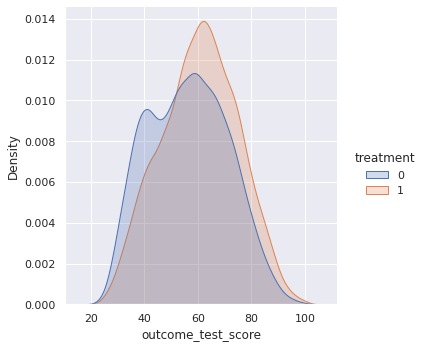

In [ ]:
# view distribution of outcome by treatment
sns.set_theme(style="darkgrid")
sns.displot(df, x='outcome_test_score', kind = 'kde', hue = 'treatment', fill = True);

In [ ]:
# check for missing values by column
print(df.isnull().mean())

outcome_test_score                     0.000
treatment                              0.000
school                                 0.000
is_female                              0.095
mother_attended_secondary_school       0.107
father_attened_secondary_school        0.113
failed_at_least_one_school_year        0.111
family_receives_cash_transfer          0.101
has_computer_with_internet_at_home     0.109
is_unemployed                          0.046
has_some_form_of_income                0.045
saves_money_for_future_purchases       0.063
intention_to_save_index                0.110
makes_list_of_expenses_every_month     0.054
negotiates_prices_or_payment_methods   0.061
financial_autonomy_index               0.112
dtype: float64


In [ ]:
# drop missing values
df = df.dropna()

In [ ]:
# verify covariates seem balanced between treatment and control
df.groupby('treatment').mean().reset_index().transpose()

,0,1
treatment,0.000,1.000
outcome_test_score,57.591,61.807
school,32290528.507,32526301.308
is_female,0.553,0.579
mother_attended_secondary_school,0.430,0.431
father_attened_secondary_school,0.393,0.395
failed_at_least_one_school_year,0.254,0.278
family_receives_cash_transfer,0.336,0.348
has_computer_with_internet_at_home,0.548,0.542
is_unemployed,0.322,0.322


In [ ]:
outcome_col = 'outcome_test_score'
treatment_col = 'treatment'
covariate_cols = list(df.drop(columns=[outcome_col]+[treatment_col]).columns)

### *a. Run the data analysis for the first method in I.c and report your code, the results of the estimation and all the metrics you described in I.d.*

In [ ]:
# run OLS of outcome on just treatment
base_ols = smf.ols('outcome_test_score ~ treatment', 
               data = df)
print(base_ols.fit(cov_type="HC1").summary())

                            OLS Regression Results                            
Dep. Variable:     outcome_test_score   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     260.0
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           6.79e-58
Time:                        03:20:04   Log-Likelihood:                -49967.
No. Observations:               12222   AIC:                         9.994e+04
Df Residuals:                   12220   BIC:                         9.995e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.5908      0.191    301.648      0.0

In [ ]:
hat = base_ols.fit(cov_type="HC1").params[base_ols.exog_names.index("treatment")]
se = base_ols.fit(cov_type="HC1").bse['treatment']
ci = [hat - 1.96*se, hat + 1.96*se]
print(f"Average Predictive Effect under Base Model using OLS: {round(hat,3)}")
print(f"SE under Base Model using OLS: {round(se,3)}")
print(f"95% CI under Base Model using OLS: {[round(i, 3) for i in ci]}")

Average Predictive Effect under Base Model using OLS: 4.216
SE under Base Model using OLS: 0.261
95% CI under Base Model using OLS: [3.703, 4.728]


In [ ]:
# run OLS of outcome on treatment and all covariates
formula = outcome_col + ' ~ ' + treatment_col + ' + ' + ' + '.join(covariate_cols)
ols_covariates = smf.ols(formula, data = df)
print(ols_covariates.fit(cov_type="HC1").summary())

                            OLS Regression Results                            
Dep. Variable:     outcome_test_score   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     153.2
Date:                Fri, 24 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:20:04   Log-Likelihood:                -49199.
No. Observations:               12222   AIC:                         9.843e+04
Df Residuals:                   12206   BIC:                         9.855e+04
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
hat = ols_covariates.fit(cov_type="HC1").params[ols_covariates.exog_names.index("treatment")]
se = ols_covariates.fit(cov_type="HC1").bse['treatment']
ci = [hat - 1.96*se, hat + 1.96*se]
print(f"Average Predictive Effect under OLS with covariates: {round(hat,3)}")
print(f"SE using under OLS with covariates: {round(se,3)}")
print(f"95% CI under OLS with covariates: {[round(i, 3) for i in ci]}")

Average Predictive Effect under OLS with covariates: 4.291
SE using under OLS with covariates: 0.246
95% CI under OLS with covariates: [3.808, 4.773]


Under the plain OLS, with and without including all the other covariates, we get a similar ATE of 4.2 and 4.3 respectively, with high statistical confidence. Including the covariates increases the adjusted R-squared from 0.021 to 0.135.

### *b. Run the data analysis for the second method in I.c and report your code, the results of the estimation  and report all the metrics you described in I.d*

In [ ]:
y = list(df.outcome_test_score)
X = df[[treatment_col] + covariate_cols]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit(X)
X_poly = poly.fit_transform(X)

var_name_mapping = dict(zip(('x{}'.format(i) for i in count()), X.columns))
var_keys = list(var_name_mapping.keys())[::-1]

features = []
for feature in poly.get_feature_names_out():
    for key in var_keys:
        feature_name = var_name_mapping[key]
        feature = re.sub(key, feature_name, feature)
    feature = re.sub(' ', '_', feature)
    features.append(feature)
X_interactions = pd.DataFrame(X_poly, columns=features)
ols_interactions = OLS(y, sm.add_constant(X_interactions)) 
print(ols_interactions.fit(cov_type="HC1").summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     2.929
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           2.21e-21
Time:                        03:20:05   Log-Likelihood:                -49087.
No. Observations:               12222   AIC:                         9.842e+04
Df Residuals:                   12101   BIC:                         9.931e+04
Df Model:                         120                                         
Covariance Type:                  HC1                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
hat = ols_interactions.fit(cov_type="HC1").params[ols_covariates.exog_names.index("treatment")]
se = ols_interactions.fit(cov_type="HC1").bse['treatment']
ci = [hat - 1.96*se, hat + 1.96*se]
print(f"Average Predictive Effect under OLS with interaction of covariates: {round(hat,3)}")
print(f"SE using under OLS with interaction of covariates: {round(se,3)}")
print(f"95% CI under OLS with interaction of covariates: {[round(i, 3) for i in ci]}")

Average Predictive Effect under OLS with interaction of covariates: 4.773
SE using under OLS with interaction of covariates: 1.574
95% CI under OLS with interaction of covariates: [1.687, 7.859]


After including the interaction terms, the coefficient on treatment increases to 4.8, still remaining highly statistically significant, and the adjusted R-squared to 0.144.

### Double LASSO

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lasso_model = lambda: make_pipeline(StandardScaler(), LassoCV(cv=cv))

def double_lasso(y, D, W):
  yres = y - lasso_model().fit(W, y).predict(W)
  Dres = D - lasso_model().fit(W, D).predict(W)
  hat = np.mean(yres * Dres) / np.mean(Dres**2)
  epsilon = yres - hat * Dres
  V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
  yrmse = np.mean(yres**2)
  drmse = np.mean(Dres**2)
  return hat, np.sqrt(V / y.shape[0]), yrmse, drmse

In [ ]:
ate, std_err, yrmse, drmse = double_lasso(df[outcome_col], df[treatment_col], df[covariate_cols])
ci = [ate - 1.96*std_err, ate + 1.96*std_err]
print(f"Average Predictive Effect with Double Lasso: {round(ate,3)}")
print(f"SE using Double Lasso with covariates: {round(std_err,3)}")
print(f"95% CI under Double Lasso with covariates: {[round(i, 3) for i in ci]}")
print(f"Y RMSE {round(yrmse,3)}")
print(f"D RMSE {round(drmse,3)}")


### Double LASSO with interaction terms

We use `PolynomialFatures` from `sklearn` to create degree=2 interaction terms between the covariates. We then estimate the ATE, and the standard error for th ATE using Double Lasso with the interaction terms.

In [ ]:
X = df[covariate_cols]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
df_interactions = pd.DataFrame(X_poly)
print(df_interactions.shape)

In [ ]:
ate_interaction, std_err_interaction, yrmse, drmse = double_lasso(df[outcome_col], df[treatment_col], df_interactions)
ci = [ate_interaction - 1.96*std_err_interaction, ate_interaction + 1.96*std_err_interaction]
print(f"Average Predictive Effect with Double Lasso on interaction terms: {round(ate_interaction,3)}")
print(f"SE using Double Lasso with covariates with interaction terms: {round(std_err_interaction,3)}")
print(f"95% CI under Double Lasso with covariates with interaction terms: {[round(i, 3) for i in ci]}")
print(f"Y RMSE {round(yrmse,3)}")
print(f"D RMSE {round(drmse,3)}")

### *c. Run the data analysis for the third method in I.c and report your code, the results of the estimation  and report all the metrics you described in I.d*

### Logistic Regression to estimate Propensity Scores

In [ ]:
# from flaml.automl.model import LogisticRegression
logregressor = LogisticRegression()
propensity_model  = logregressor.fit(df[covariate_cols], df[treatment_col])
propensity_scores = propensity_model.predict_proba(df[covariate_cols])

In [ ]:
propensity_scores

In [ ]:
log_reg = sm.Logit(df[treatment_col], df[covariate_cols]).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.691549
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                12222
Model:                          Logit   Df Residuals:                    12208
Method:                           MLE   Df Model:                           13
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                0.001805
Time:                        03:31:11   Log-Likelihood:                -8452.1
converged:                       True   LL-Null:                       -8467.4
Covariance Type:            nonrobust   LLR p-value:                  0.003892
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
school                                5.324e-10   1.64e-

**Only gender and failed_at_least_one_school_year are significant. It seems that there is almost no difference between using logistic regression and using the frequency of treatment.**

In [ ]:
from sklearn.model_selection import train_test_split
X, Xval, D, Dval, y, yval = train_test_split(df[covariate_cols], df[treatment_col], df[outcome_col], train_size=.6, shuffle=True, random_state=123)
Xval, Xtest, Dval, Dtest, yval, ytest = train_test_split(Xval, Dval, yval, train_size=.5, shuffle=True, random_state=123)
split_type = 'auto'
groups = None
groupsval, groupstest = None, None
time_budget = 120 #600 # time budget for auto-ml in seconds (advisable at least 120)
verbose = 0 # verbosity of auto-ml
n_splits = 5 

In [ ]:
model_reg = auto_reg(np.column_stack((D, X)), y.values, groups=groups, n_splits=n_splits, split_type=split_type, 
                        verbose=verbose, time_budget=time_budget)
model_y = auto_reg(X, y.values, groups=groups, n_splits=n_splits, split_type=split_type, 
                    verbose=verbose, time_budget=time_budget)
model_reg_zero = auto_reg(X[D==0], y[D==0].values, groups=groups, n_splits=n_splits, split_type=split_type, 
                            verbose=verbose, time_budget=time_budget)
model_reg_one = auto_reg(X[D==1], y[D==1].values, groups=groups, n_splits=n_splits, split_type=split_type, 
                            verbose=verbose, time_budget=time_budget)
model_t = auto_clf(X, D.values, groups=groups, n_splits=n_splits, split_type=split_type, 
                   verbose=verbose, time_budget=time_budget)

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [ ]:
if groups is None:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    splits = list(cv.split(X, D))
else:
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
    splits = list(cv.split(X, D, groups=groups))

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg = model_reg().fit(DX[train], y.values[train])
    reg_preds[test] = reg.predict(DX[test])
    reg_one_preds[test] = reg.predict(np.column_stack([np.ones(len(test)), X.iloc[test]]))
    reg_zero_preds[test] = reg.predict(np.column_stack([np.zeros(len(test)), X.iloc[test]]))

    reg_zero = model_reg_zero().fit(X.iloc[train][D.values[train]==0], y.values[train][D.values[train]==0])
    reg_one = model_reg_one().fit(X.iloc[train][D.values[train]==1], y.values[train][D.values[train]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D.values[test]) + reg_one_preds_t[test] * D.values[test]

res_preds = cross_val_predict(model_y(), X, y, cv=splits)
prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

In [ ]:
# Generic CATE
model_final_fn = lambda X, y: auto_reg(X, y, groups=groups,
                                       n_splits=n_splits, split_type=split_type, 
                                       verbose=verbose, time_budget=time_budget)

## Single learner:

In [ ]:
# slearner
slearner_best = model_final_fn(X, reg_one_preds - reg_zero_preds)
slearner = slearner_best().fit(X, reg_one_preds - reg_zero_preds)
slearner_cates = slearner.predict(X)

In [ ]:
# ATE 
np.mean(slearner_cates)

4.361214486593398

## T learner

In [ ]:
# tlearner
tlearner_best = model_final_fn(X, reg_one_preds_t - reg_zero_preds_t)
tlearner = tlearner_best().fit(X, reg_one_preds_t - reg_zero_preds_t)
tlearner_cates = tlearner.predict(X)

In [ ]:
# ATE 
np.mean(tlearner_cates)

4.424523336445955

##Cross learner:

In [ ]:
# xlearner
tau1_preds = y.values[D==1] - reg_zero_preds_t[D==1]
tau0_preds = reg_one_preds_t[D==0] - y.values[D==0]
tau1 = model_final_fn(X[D==1], tau1_preds)().fit(X[D==1], tau1_preds)
tau0 = model_final_fn(X[D==0], tau0_preds)().fit(X[D==0], tau0_preds)
xtarget = prop_preds * tau0.predict(X) + (1 - prop_preds) * tau1.predict(X)
xlearner = model_final_fn(X, xtarget)().fit(X, xtarget)
xlearner_cates = xlearner.predict(X)

In [ ]:
# ATE
np.mean(xlearner_cates)

4.600819252806745

## DR learner:

In [ ]:
# drlearner
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y.values - reg_preds_t) * (D.values - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
drlearner_best = model_final_fn(X, dr_preds)
drlearner = drlearner_best().fit(X, dr_preds)
drlearner_cates = drlearner.predict(X)

In [ ]:
# ATE
np.mean(drlearner_cates)

5.11928

In [ ]:
# drlearner with the real probability of assignment instead of a model for the
# propensity score
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y.values - reg_preds_t) * (D.values - 0.51) / (0.51 * (1 - 0.51))
drlearner_best = model_final_fn(X, dr_preds)
drlearner = drlearner_best().fit(X, dr_preds)
drlearner_cates = drlearner.predict(X)

In [ ]:
# ATE
np.mean(drlearner_cates)

4.477877580758076

**Using the real probability of assignment improves the results.**

## Residual learner:

In [ ]:
# rlearner
yres = y.values - res_preds
Dres = D.values - prop_preds
Dres = np.clip(Dres, .001, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -.001) * (Dres < 0)

rlearner_fn = auto_weighted_reg(X, yres / Dres, sample_weight=Dres**2, groups=groups,
                                n_splits=n_splits, verbose=verbose, time_budget=time_budget)
rlearner = rlearner_fn().fit(X, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(X)

In [ ]:
# ATE
np.mean(rlearner_cates)

7.612479

In [ ]:
# rlearner
yres = y.values - res_preds
Dres = D.values - 0.51

rlearner_fn = auto_weighted_reg(X, yres / Dres, sample_weight=Dres**2, groups=groups,
                                n_splits=n_splits, verbose=verbose, time_budget=time_budget)
rlearner = rlearner_fn().fit(X, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(X)

In [ ]:
# ATE
np.mean(rlearner_cates)

3.266012723240915

## R-Score

In [ ]:
# r-score
yres_val = yval - model_y().fit(X, y).predict(Xval)
Dres_val = Dval - model_t().fit(X, D).predict(Xval)

overall_ate_val_r = np.mean(yres_val * Dres_val) / np.mean(Dres_val**2)

def rscore(cate_preds): 
    rscore_t = np.mean((yres_val - cate_preds * Dres_val)**2)
    rscore_b = np.mean((yres_val - overall_ate_val_r * Dres_val)**2)
    return 1 - rscore_t / rscore_b

In [ ]:
print(f"R-Score -- S-Learner: {rscore(slearner.predict(Xval))}")
print(f"R-Score -- T-Learner: {rscore(tlearner.predict(Xval))}")
print(f"R-Score -- DR-Learner: {rscore(drlearner.predict(Xval))}")
print(f"R-Score -- X-Learner: {rscore(xlearner.predict(Xval))}")
print(f"R-Score -- R-Learner: {rscore(rlearner.predict(Xval))}")


R-Score -- S-Learner: 0.00018629232509825844
R-Score -- T-Learner: 0.0014251826574824822
R-Score -- DR-Learner: -0.0004221794204508633
R-Score -- X-Learner: 0.001284771172464283
R-Score -- R-Learner: -0.00015007586944637552


## DR-Score

In [ ]:
def calculate_dr_outcomes(Xtrain, Dtrain, ytrain, groupstrain, Xval, Dval, yval, groupsval):

    reg_zero = model_reg_zero().fit(Xtrain[Dtrain==0], ytrain[Dtrain==0])
    reg_one = model_reg_one().fit(Xtrain[Dtrain==1], ytrain[Dtrain==1])
    reg_zero_preds_t = reg_zero.predict(Xval)
    reg_one_preds_t = reg_one.predict(Xval)
    reg_preds_t = reg_zero_preds_t * (1 - Dval) + reg_one_preds_t * Dval
    prop_preds = model_t().fit(Xtrain, Dtrain).predict(Xval)

    dr = reg_one_preds_t - reg_zero_preds_t
    reisz = (Dval - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
    dr += (yval - reg_preds_t) * reisz

    return dr

dr_val = calculate_dr_outcomes(X, D, y, groups, Xval, Dval, yval, groupsval)

overall_ate_val_dr = np.mean(dr_val)

def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return 1 - drscore_t / drscore_b

In [ ]:
print(f"R-Score -- S-Learner: {drscore(slearner.predict(Xval))}")
print(f"R-Score -- T-Learner: {drscore(tlearner.predict(Xval))}")
print(f"R-Score -- DR-Learner: {drscore(drlearner.predict(Xval))}")
print(f"R-Score -- X-Learner: {drscore(xlearner.predict(Xval))}")
print(f"R-Score -- R-Learner: {drscore(rlearner.predict(Xval))}")

R-Score -- S-Learner: 0.013208060550198408
R-Score -- T-Learner: 0.07196400902380706
R-Score -- DR-Learner: 0.03205383166035247
R-Score -- X-Learner: 0.055020669388129106
R-Score -- R-Learner: 0.009516230314603025


## Ensemble

In [ ]:
from sklearn.base import BaseEstimator

scorer = drscore
score_name = 'DRscore'
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner', 'drlearner_const']
models = [slearner, tlearner, xlearner, drlearner, rlearner]
scores = [scorer(model.predict(Xval)) for model in models]


class Ensemble(BaseEstimator):
    
    def __init__(self, names, models, weights, intercept=0):
        self.names = names
        self.models = models
        self.weights = weights
        self.intercept = intercept
    
    def predict(self, X):
        wcate = np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)
        return self.intercept + wcate

eta_grid = np.logspace(-5, 5, 10)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * np.array(scores))
    ensemble = Ensemble(names, models, weights)
    ens[eta] = (ensemble, scorer(ensemble.predict(Xval)))

score_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= score_best:
        score_best = ens[eta][1]
        eta_best = eta

softmax_ensemble = ens[eta_best][0]
softmax_ensemble

Ensemble(models=[AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb950dbce50>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb953a23a60>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb94bcbb310>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb949751490>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb94bc8ffa0>)],
         names=['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner',
                'drlearner_const'],
         weights=array([5.04328156e-16, 9.99961208e-01, 3.87917078e-05, 4.06687330e-11,
       5.51486947e-17]))

In [ ]:
from sklearn.linear_model import RidgeCV

F = np.array([m.predict(Xval) for m in models]).T
meansF = np.mean(F, axis=0)
F = F - meansF
# One of LassoCV(fit_intercept=False) or ElasticNetCV(fit_intercept=False) or
# or LinearRegression(fit_intercept=False) or LassoCV(positive=True, fit_intercept=False)
stacker = LassoCV(fit_intercept=False)
if score_name == 'DRscore':
    stacker.fit(F, dr_val - np.mean(dr_preds))
    intercept = np.mean(dr_preds) - meansF @ stacker.coef_
    stack_ensemble = Ensemble(names, models, stacker.coef_, intercept)
elif score_name == 'Rscore':
    # we will avoid penalizing the intercept of the CATE by multiplying the constant 1
    # by a large number; equivalently this divides the penalty for that parameter by that number
    stacker.fit(F * Dres_val.reshape(-1, 1), yres_val - np.mean(dr_preds) * Dres_val)
    intercept = np.mean(dr_preds) - meansF @ stacker.coef_
    stack_ensemble = Ensemble(names, models, stacker.coef_, intercept)

stack_ensemble

Ensemble(intercept=-0.19126261261767485,
         models=[AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb950dbce50>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb953a23a60>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb94bcbb310>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb949751490>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x7fb94bc8ffa0>)],
         names=['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner',
                'drlearner_const'],
         weights=array([-0.        ,  0.81633771,  0.06598891,  0.18570266, -0.        ]))

### Hypothesis Test Based on Doubly Robust Best-Linear Predictor 

In [ ]:
overall_best = stack_ensemble
dr_test = calculate_dr_outcomes(X, D, y, groups, Xtest, Dtest, ytest, groupstest)
cate_test = overall_best.predict(Xtest)
OLS(dr_test, np.stack((np.ones(len(dr_test)), cate_test), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     226.4
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           5.32e-49
Time:                        04:01:36   Log-Likelihood:                -10211.
No. Observations:                2445   AIC:                         2.043e+04
Df Residuals:                    2443   BIC:                         2.044e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0601      0.443     -0.135      0.892      -0.930       0.810
x1             1.0103      0.067     15.047      0.000       0.879       1.142
==============================================================================
Omnibus:                     1972.288   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3721335.402
Skew:                           2.354   Prob(JB):                         0.00
Kurtosis:                     194.066   Cond. No.                         9.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The coefficient is close to 1 as expected and significant.**

## Uplifting Curves


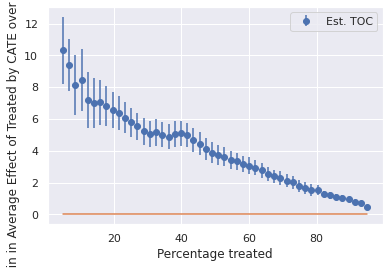

In [ ]:

# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Xval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0])) # influence function representation of the TOC at each quantile
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    toc[it]= np.mean(dr_test[inds]) - ate # tau(q) := E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    # influence function for the tau(q); it is a standard influence function of a "covariance"
    toc_psi[it, :] = (dr_test - ate) * (inds / group_prob - 1) - toc[it]
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n) # standard error of tau(q)

plt.errorbar(100 - ugrid, toc, yerr=1.96*toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

2.9762965444852703


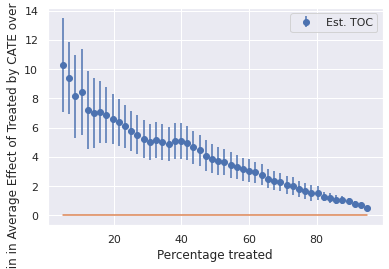

In [ ]:
## Multiplier Boostrap CI
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (toc_psi / toc_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (toc_psi / toc_std.reshape(-1, 1)) @ w / n

max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value*toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

2.751541220537251


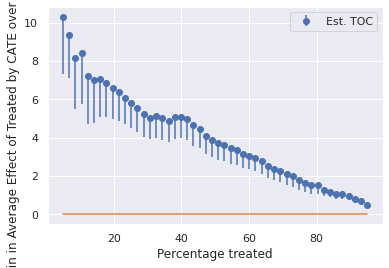

In [ ]:
## one-sided test for identifying CATE
min_mboot = np.min(mboot, axis=0)
uniform_one_side_critical_value = np.abs(np.percentile(min_mboot, 5))
print(uniform_one_side_critical_value)
plt.errorbar(100 - ugrid, toc,
             yerr=[uniform_one_side_critical_value*toc_std, np.zeros(len(toc))], fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

In [ ]:
print(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std)}')

Heterogeneity Statistic: 7.349081395177081


In [ ]:
autoc_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(toc[:-1] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(f'AUTOC: {autoc:.4f}, s.e.: {autoc_stderr:.4f}, '
      f'One-Sided 95% CI=[{autoc - scipy.stats.norm.ppf(.95) * autoc_stderr:.4f}, Infty]')

AUTOC: 3.5544, s.e.: 0.2293, One-Sided 95% CI=[3.1772, Infty]


**Since the confidence interval does not contain zero, then we have again detected heterogeneity.**

In [ ]:
from statsmodels.formula.api import ols
xfeat = 'financial_autonomy_index'
df2 = X.copy()
df2['dr'] = dr_preds
lr = ols('dr ~ financial_autonomy_index', df2).fit(cov_type='HC1')
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     dr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.930
Date:                Fri, 24 Mar 2023   Prob (F-statistic):             0.0264
Time:                        04:17:15   Log-Likelihood:                -34427.
No. Observations:                7333   AIC:                         6.886e+04
Df Residuals:                    7331   BIC:                         6.887e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 110, 20)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)

In [ ]:
## Confidence Intervals with Causal Forests
!pip install econml
from econml.grf import CausalForest

yres = y - res_preds
Dres = D - prop_preds
cf = CausalForest(4000, criterion='het', max_depth=5, max_samples=.4, min_samples_leaf=50, min_weight_fraction_leaf=.0)
cf.fit(X, Dres, yres)
top_feat = np.argsort(cf.feature_importances_)[-1]
print(X.columns[top_feat])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


financial_autonomy_index


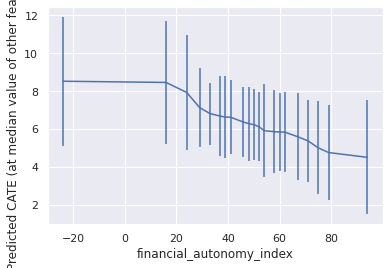

In [ ]:
grid = np.unique(np.percentile(X.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [ ]:
## Confidence Intervals with Double Forests
from econml.grf import RegressionForest

drrf = RegressionForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50,
                       min_weight_fraction_leaf=.0)
drrf.fit(X, dr_preds)
top_feat = np.argsort(drrf.feature_importances_)[-1]
print(X.columns[top_feat])

school


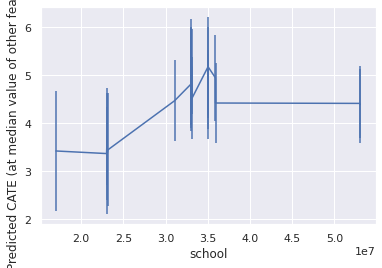

In [ ]:
grid = np.unique(np.percentile(X.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

CATE for different groups (female vs male students) to see if there are heterogeneous treatment effects here

In [ ]:
np.mean(drlearner.predict(X[X.is_female == 1]))

4.350783915361541

In [ ]:
np.mean(drlearner.predict(X[X.is_female == 0]))

4.645900396790542

**There does not appear to be a significant difference in ATE for these groups, although slightly higher for males at 4.65 instead of 4.35 for females.**

### *d. Compare the results of the three methods and what do the corresponding treatment effects imply about the real world. Are the results consistent with each other and if not what could be causing the difference? Are any findings statistically significant? Are the numbers returned by the methods reasonable? If they are not what violation of the assumptions of each of the methods could have caused this. Are there any of the assumptions of the methods potentially being violated in the way the dataset was collected.*

**All three methods show a positive average treatment effect, indicating that participation in the school financial education program did improve students' performance on the financial proficiency test at a statistically significant level.**

**Across all three methods, and including among the different meta-learners, we see an ATE consistently ranging from around 4.2-4.8, except for the R-learner which shows an ATE of 2 or 8 depending on the propensity score. The emsemble places the least (or zero) weight on the s-learner and the r-learner. The ATE returned by most methods suggests that participating in the study increased average test score by around 4.5 points (out of 100), which seems reasonable. The causal effect of the treatment on financial proficiency does not appear to differ between female and male students.**